## 1. Collect Evidence

In the second phase of SDMT, we collect _evidence_ to attest to the fact that the model realized the properties specified in the previous phase.

We define and instantiate `Measurement`s to generate this evidence. Each individual piece of evidence is a `Result`. Once `Result`s are produced, we can persist them to an _artifact store_ to maintain our evidence across sessions. 

#### Preliminaries

In [10]:
# Preliminaries for loading the package locally
import os
import sys

def package_root() -> str:
    """Resolve the path to the project root."""
    return os.path.abspath(os.path.join(os.getcwd(), "..", "src/"))

sys.path.append(package_root())
sys.path.append(os.getcwd())

In [11]:
import os
from pathlib import Path

# The path at which datasets are stored
DATASETS_DIR = Path(os.getcwd()) / "data"
# The path at which models are stored
MODELS_DIR = Path(os.getcwd()) / "models"
# The path at which media is stored
MEDIA_DIR = Path(os.getcwd()) / "media"

In [12]:
import pickle
from typing import Tuple

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import tree

def load_data() -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Load machine learning dataset.
    :return (X_train, X_test, y_train, y_test)
    """
    iris = load_iris(as_frame=True)
    X, y = iris.data, iris.target
    return train_test_split(X, y, test_size=0.2)

def train_model():
    """Train a classifier and save."""
    X_train, _, y_train, _ = load_data()

    clf = tree.DecisionTreeClassifier()
    clf.fit(X_train.to_numpy(), y_train.to_numpy())
    with (MODELS_DIR / "model.pkl").open("wb") as f:
        pickle.dump(clf, f)

train_model()

In [13]:
# Save the training dataset for use by training procedure
X_train, _, y_train, _ = load_data()
X_train.to_csv(DATASETS_DIR / "data.csv")
y_train.to_csv(DATASETS_DIR / "target.csv")

#### Initialize MLTE Context

In [14]:
import mlte

store_path = os.path.join(os.getcwd(), "store")

mlte.set_model("IrisClassifier", "0.0.1")
mlte.set_artifact_store_uri(f"local://{store_path}")

#### Storage Cost Measurements

This section demonstrates the simplest possible use-case. We import a MLTE-defined `Measurement`, which is then invoked to produce a `Result`. This result can then be inspected and automatically saved to the artifact store.

In [15]:
from mlte.measurement.storage import LocalObjectSize
from mlte.measurement.result import Integer

# Create a measurement
measurement = LocalObjectSize("model size")
# Execute the measurement
size: Integer = measurement.evaluate(MODELS_DIR / "model.pkl")

# Inspec results
print(size)

# Save to artifact store
size.save()

2270


#### Training Cost Measurements

Evidence in this section is largely the same as that demonstrated in the previous section, except it requires some additional setup from the user's perspective. Again, we utilize MLTE-defined `Measurement`s to produce `Result`s that can then be saved to the artifact store.

In [16]:
import sys
import threading
import subprocess

def interpreter_path() -> Path:
    """Get the path to the current interpreter."""
    return Path(sys.executable)

def script_path() -> Path:
    """Get the path to the training script."""
    return (Path(os.getcwd()) / "train.py").absolute()

def spawn_training_job() -> int:
    """Spawn the training job and return its process identifier."""
    python = interpreter_path()
    command = [
        str(python),
        str(script_path()),
        "--dataset-dir", str(DATASETS_DIR.absolute()),
        "--models-dir", str(MODELS_DIR.absolute())
    ]
    p = subprocess.Popen(command)
    thread = threading.Thread(target=lambda: p.wait())
    thread.start()
    return p.pid

The first evidence we collect are CPU utilization statistics for a local training job.

In [17]:
from mlte.measurement.cpu import LocalProcessCPUUtilization, CPUStatistics

# Create a measurement
measurement = LocalProcessCPUUtilization("training cpu")
# Execute the measurement
cpu_stats: CPUStatistics = measurement.evaluate(spawn_training_job())

# Inspect results
print(cpu_stats)

# Save to artifact store
cpu_stats.save()

Average: 1.26%
Minimum: 0.00%
Maximum: 2.65%


Next, we perform a similar procedure to measure the memory consumption of a local training job.

In [18]:
from mlte.measurement.memory import LocalProcessMemoryConsumption, MemoryStatistics

# Create a measurement
measurement = LocalProcessMemoryConsumption("training memory")
# Execute the measurement
mem_stats: MemoryStatistics = measurement.evaluate(spawn_training_job())

# Inspect results
print(mem_stats)

# Save to artifact store
mem_stats.save()

Average: 506526
Minimum: 16188
Maximum: 751696


#### Task Efficacy Measurements

Evidence collected in this section demonstrates MLTE's flexibility in handling inputs from external libraries and in different media types.

In [19]:
import pickle
from sklearn import tree

def load_model():
    """Load a trained model."""
    path = MODELS_DIR / "model.pkl"
    with path.open("rb") as f:
        return pickle.load(f)

train_model()

In [20]:
# Load the test dataset
_, X_test, _, y_test = load_data()

# Load the model
model = load_model()

# Make predictions
y_pred = model.predict(X_test.to_numpy())

In this first example, we simply wrap the output from `accuracy_score` with a builtin MLTE type (`Real`) to integrate it with our growing collection of evidence.

In [21]:
from sklearn.metrics import accuracy_score

from mlte.measurement.result import Real
from mlte.measurement import MeasurementMetadata, Identifier

# Evaluate performance
accuracy = Real(
    MeasurementMetadata("accuracy_score", Identifier("accuracy")),
    accuracy_score(y_test, y_pred)
)

# Inspect result
print(accuracy)

# Save to artifact store
accuracy.save()

1.0


In this next example, we define a custom `Result` type to cope with the output of a third-party library that is not supported by a MLTE builtin.

In [22]:
from sklearn.metrics import confusion_matrix
from mlte.measurement import MeasurementMetadata, Identifier
from confusion_matrix import ConfusionMatrix

# Generate result
matrix = ConfusionMatrix(
    MeasurementMetadata("confusion_matrix", Identifier("confusion matrix")),
    confusion_matrix(y_test, y_pred)
)

# Inspect
print(matrix)

# Save to artifact store
matrix.save()

[[17  0  0]
 [ 0  8  0]
 [ 0  0  5]]


In this final example, we demonstrate the ability to integrate other forms of media in our evidence collection process.

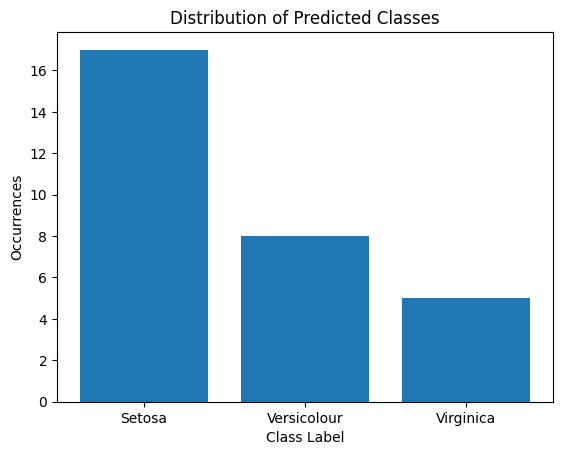

In [23]:
import matplotlib.pyplot as plt

from mlte.measurement.result import Image

x = ["Setosa", "Versicolour", "Virginica"]
y = [sum(1 for value in y_pred if value == target) for target in [0, 1, 2]]

plt.bar(x, y)
plt.title("Distribution of Predicted Classes")
plt.xlabel("Class Label")
plt.xticks([0, 1, 2])
plt.ylabel("Occurrences")
plt.savefig(MEDIA_DIR / "classes.png")

img = Image(
    MeasurementMetadata("plt.bar", Identifier("class distribution")),
    MEDIA_DIR / "classes.png"
)
img.save()